In this notebook we
<ol>
    <li> Explore if a voting model seems helpful </li>
    <li> Create a voting model based on the most successful kNN, logistic regression, SVC, and random forest models from before </li>
    <ol>
        <li> Using all the TE features </li>
        <li> Using only the 3 important features </li>
        <li> Using only the 3 important features on the LR and SVC models </li>
    </ol>
    </ol>
    
 The last model, when assuming 1 when the votes are tied, performed the best.

## Importing packages and data

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split, StratifiedKFold

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


In [4]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [5]:
from matplotlib import pyplot as plt

In [6]:
from sklearn.metrics import accuracy_score, recall_score

In [7]:
df=pd.read_csv('../Data/clean_data_3.csv')

## Splitting the data

In [7]:
train, val = train_test_split(df,
                              test_size=0.1,
                              stratify=df["Y"],
                              shuffle=True,
                              random_state=123)

## Helper functions and shortcuts

In [8]:
features2=['SEX_TE', 
           'EDUCATION_TE', 
           'MARRIAGE_TE', 
           'PAY_1_TE',
           'PAY_AMT1',
           'AGE_BY10_TE', 
           'AVE_PAY', 
           'AGE/LIM', 
           'AVE_BILL_AMT',
           'AVE_BILL_AMT/LIM', 
           'AVE_PAY_AMT',
           'AVE_PAY_AMT/LIM',  
           'AVE_PAY/BILL', 
           'UNPAID_MONTHS']

In [9]:
features_ltd=['PAY_1_TE','AVE_PAY','UNPAID_MONTHS']

## Exploring if we think a voting model is feasible

In [11]:
## K nearest neighbors
knn = Pipeline([('scale', StandardScaler()),
                   ('pca', PCA()),
                   ('knn', KNeighborsClassifier(3))])

## Logistic Regression
lr = LogisticRegression(C=1)

## SVC
svm = Pipeline([('scale', StandardScaler()),
                   ('svm', SVC(C = 1))])

## Random Forest
rf = RandomForestClassifier(max_depth=6, 
                            n_estimators=2)

##### Fit all of the models #####
knn.fit(train[features2], train['Y'])
lr.fit(train[['PAY_1_TE','AVE_PAY','UNPAID_MONTHS']], train['Y'])
svm.fit(train[['PAY_1_TE','AVE_PAY','UNPAID_MONTHS']], train['Y'])
rf.fit(train[features2], train['Y'])
  
    
##### Get predictions #####
knn_pred = knn.predict(train[features2])
log_pred = lr.predict(train[['PAY_1_TE','AVE_PAY','UNPAID_MONTHS']])
svm_pred = svm.predict(train[['PAY_1_TE','AVE_PAY','UNPAID_MONTHS']])
rf_pred = rf.predict(train[features2])


##### This records what observations in the validation set
##### Each model got wrong
wrongs = np.zeros((4, len(train)))
wrongs[0,:] = knn_pred != train['Y'].values
wrongs[1,:] = log_pred != train['Y'].values
wrongs[2,:] = svm_pred != train['Y'].values
wrongs[3,:] = rf_pred != train['Y'].values

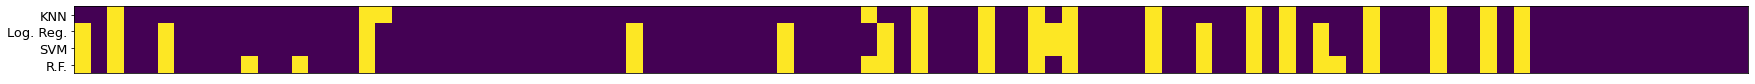

In [21]:
### A bright spot indicates the model was wrong for that observation
plt.figure(figsize=(30,40))
plt.imshow(wrongs[:,0:100])

plt.xticks([])
plt.yticks([0,1,2,3], 
              ["KNN", "Log. Reg.", "SVM", "R.F."],
              fontsize=13)
plt.show()

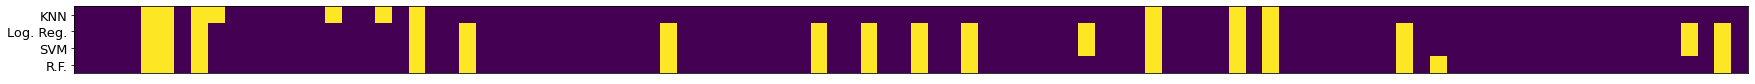

In [22]:
plt.figure(figsize=(30,40))
plt.imshow(wrongs[:,100:200])

plt.xticks([])
plt.yticks([0,1,2,3], 
              ["KNN", "Log. Reg.", "SVM", "R.F."],
              fontsize=13)
plt.show()

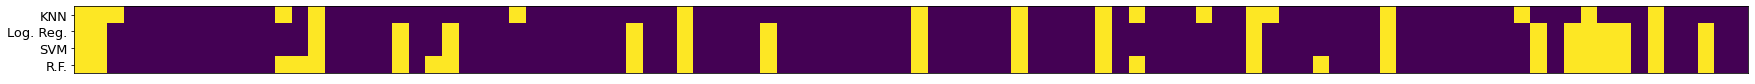

In [23]:
plt.figure(figsize=(30,40))
plt.imshow(wrongs[:,200:300])

plt.xticks([])
plt.yticks([0,1,2,3], 
              ["KNN", "Log. Reg.", "SVM", "R.F."],
              fontsize=13)
plt.show()

I feel like kNN is behaving very differently from the others, but most of the time all the models are wrong together.

## Building a voting model

In [24]:
def vote(features_1,wts=[1,1,1,1], splits=5):
    '''creates a voting classifier using the 4 models discussed previously
    uses feature_1 
    uses weights=wts
    outputs a matrix of accuracy and recall for a splits-fold split'''
    
    accs=np.zeros(splits)
    recs = np.zeros(splits)
    
    kfold=StratifiedKFold(n_splits=splits,
                    shuffle=True,
                    random_state=123)
    
        
    x=0
    for train_index, test_index in kfold.split(train[features_1], train['Y']):

        # make model
        vote=VotingClassifier([('lr', Pipeline([('scale', StandardScaler()),
                                              ('PCA', PCA()),
                                              ('logreg', LogisticRegression(C=1))
                                              ])),
                               ('knn',Pipeline([('scale', StandardScaler()),
                                               ('PCA', PCA()),
                                               ('kNN', KNeighborsClassifier(n_neighbors=3))])),
                               ('rf', RandomForestClassifier(n_estimators=2,
                                                             max_depth=6)),
                               ('svc', Pipeline([('scale', StandardScaler()),
                                                 ('svm', SVC(max_iter=100000))]))
                              ],
                             weights=wts)
        
        vote.fit(train.iloc[train_index][features_1], train.iloc[train_index]['Y'])
        
        pred=vote.predict(train.iloc[test_index][features_1])

        # add metrics to the tables
        accs[x]=accuracy_score(train.iloc[test_index]['Y'], pred)
        recs[x]=recall_score(train.iloc[test_index]['Y'], pred, zero_division=0)
        x=x+1
    
    return([accs, recs])

In [25]:
metrics_1=vote(features2)

In [32]:
print('Using all features:')
print('Accuracy')
print(np.round(np.mean(metrics_1[0]),4))
print('Recall')
print(np.round(np.mean(metrics_1[1]),4))

Using all features:
Accuracy
0.8188
Recall
0.33


In [33]:
metrics_2=vote(features_ltd)

In [34]:
metrics_2

[array([0.81648148, 0.81740741, 0.81444444, 0.83      , 0.82296296]),
 array([0.33807531, 0.34895397, 0.33082077, 0.38023451, 0.38693467])]

In [36]:
print('Using limited features:')
print('Accuracy')
print(np.round(np.mean(metrics_2[0]),4))
print('Recall')
print(np.round(np.mean(metrics_2[1]),4))

Using limited features:
Accuracy
0.8203
Recall
0.357


In [37]:
metrics_3 = vote(features2, wts=[1,3,1,1])
metrics_3

[array([0.80611111, 0.80944444, 0.80537037, 0.82074074, 0.81240741]),
 array([0.27196653, 0.27698745, 0.28056951, 0.31574539, 0.30904523])]

In [38]:
print('Using all features and weights:')
print('Accuracy')
print(np.round(np.mean(metrics_3[0]),4))
print('Recall')
print(np.round(np.mean(metrics_3[1]),4))

Using all features and weights:
Accuracy
0.8108
Recall
0.2909


I was not expecting recall to go down while weighting kNN higher

In [39]:
for i in [0,0.25,0.5,-.75,1,2,3]:
    metrics=vote(features2, wts=[1,i,1,1])
    print('weights: ' + str([1,i,1,1]))
    print(np.mean(metrics[0]))
    print(np.mean(metrics[1]))
    print()

weights: [1, 0, 1, 1]
0.8194814814814816
0.34712642711465275

weights: [1, 0.25, 1, 1]
0.8207777777777778
0.35298388735869024

weights: [1, 0.5, 1, 1]
0.8205925925925925
0.3554988330775215

weights: [1, -0.75, 1, 1]
0.820037037037037
0.3479612848061787

weights: [1, 1, 1, 1]
0.8186666666666665
0.3277021088707134

weights: [1, 2, 1, 1]
0.8171111111111111
0.34327551285016433

weights: [1, 3, 1, 1]
0.8113333333333334
0.2938748133975316



In [40]:
for i in [0,0.25,0.5,-.75,1,2,3]:
    metrics=vote(features_ltd, wts=[1,i,1,1])
    print('weights: ' + str([1,i,1,1]))
    print(np.mean(metrics[0]))
    print(np.mean(metrics[1]))
    print()

weights: [1, 0, 1, 1]
0.8198518518518518
0.36554417835341285

weights: [1, 0.25, 1, 1]
0.8197407407407408
0.3637016322897612

weights: [1, 0.5, 1, 1]
0.8197407407407408
0.3637016322897612

weights: [1, -0.75, 1, 1]
0.8198148148148148
0.3623630004976065

weights: [1, 1, 1, 1]
0.8198888888888888
0.3534868204341092

weights: [1, 2, 1, 1]
0.8185925925925928
0.3630321762228156

weights: [1, 3, 1, 1]
0.813962962962963
0.2948743718592965



## Building a second voting model that uses different features for different voters

In [47]:
for i in range(20):
    print(np.random.rand(1))

[0.12817961]
[0.74091092]
[0.12759393]
[0.07245489]
[0.14387236]
[0.66019199]
[0.16743901]
[0.32199833]
[0.25554126]
[0.5811914]
[0.89676552]
[0.07184739]
[0.15458375]
[0.0841257]
[0.83183766]
[0.49491863]
[0.86071964]
[0.22422648]
[0.80602765]
[0.2586946]


In [65]:
def vote2(P,features_1=features2, features_2=features_ltd,wts=[1,1], splits=5):
    '''creates a voting classifier using the 4 models discussed previously
    uses feature_1 
    uses weights=wts
    outputs a matrix of accuracy and recall for a splits-fold split'''
    
    accs=np.zeros(splits)
    recs = np.zeros(splits)
    counts=np.zeros(splits)
    
    kfold=StratifiedKFold(n_splits=splits,
                    shuffle=True,
                    random_state=123)
    
        
    x=0
    for train_index, test_index in kfold.split(train[features_1], train['Y']):
        
        #make the individual models
        lr=Pipeline([('scale', StandardScaler()),
                                              ('PCA', PCA()),
                                              ('logreg', LogisticRegression(C=1))
                                              ])
        knn=Pipeline([('scale', StandardScaler()),
                                               ('PCA', PCA()),
                                               ('kNN', KNeighborsClassifier(n_neighbors=3))])
        rf=RandomForestClassifier(n_estimators=2,
                                                             max_depth=6)
        svc=Pipeline([('scale', StandardScaler()),
                                                 ('svm', SVC(max_iter=100000))])
        
        
        lr.fit(train.iloc[train_index][features_2], train.iloc[train_index]['Y'])
        knn.fit(train.iloc[train_index][features_1], train.iloc[train_index]['Y'])
        rf.fit(train.iloc[train_index][features_1], train.iloc[train_index]['Y'])
        svc.fit(train.iloc[train_index][features_2], train.iloc[train_index]['Y'])
        
        
        pred_lr=lr.predict(train.iloc[test_index][features_2])
        pred_knn=knn.predict(train.iloc[test_index][features_1])
        pred_rf=rf.predict(train.iloc[test_index][features_1])
        pred_svc=svc.predict(train.iloc[test_index][features_2])
        
        count=0
        #vote!!
        pred=[]
        for i in range(len(test_index)):
            votes=pred_lr[i] + pred_knn[i]+ pred_rf[i] + pred_svc[i]
            if votes > 2:
                pred.append(1)
            if votes <2:
                pred.append(0)
            if votes == 2:
                count=count+1
                guess=np.random.rand(1)
                if guess<=P:
                    pred.append(1)
                else:
                    pred.append(0)
        

        # add metrics to the tables
        accs[x]=accuracy_score(train.iloc[test_index]['Y'], pred)
        recs[x]=recall_score(train.iloc[test_index]['Y'], pred, zero_division=0)
        counts[x]=count
        x=x+1
    
    return([accs, recs, counts])

In [55]:
metrics_4= vote2(0.5)

In [56]:
metrics_4

[array([0.81574074, 0.81814815, 0.8137037 , 0.82944444, 0.82462963]),
 array([0.34728033, 0.34225941, 0.34422111, 0.38358459, 0.37772194])]

In [68]:
print('Practice with vote2')
print('Accuracy')
print(np.round(np.mean(metrics_4[0]),4))
print('Recall')
print(np.round(np.mean(metrics_4[1]),4))


Practice with vote2
Accuracy
0.8203
Recall
0.359


In [61]:
main_p= train['Y'].value_counts()[1]/len(train)

In [70]:
for p in [0,main_p, 0.5, 1-main_p, 1]:
        temp_metrics=vote2(p)
        print('P='+str(p))
        print('Accuracy')
        print(np.round(np.mean(temp_metrics[0]),4))
        print('Recall')
        print(np.round(np.mean(temp_metrics[1]),4))
        print('counts')
        print(temp_metrics[2])
        print()

P=0
Accuracy
0.82
Recall
0.3436
counts
[ 63. 114.  94.  81.  76.]

P=0.22118518518518518
Accuracy
0.8188
Recall
0.348
counts
[ 97.  88.  82. 106.  70.]

P=0.5
Accuracy
0.819
Recall
0.3609
counts
[ 94.  93.  95. 130.  86.]

P=0.7788148148148148
Accuracy
0.8193
Recall
0.3726
counts
[112.  79.  98. 102.  72.]

P=1
Accuracy
0.82
Recall
0.3815
counts
[81. 85. 82. 95. 59.]



## testing against the validation data

In [74]:
lr=Pipeline([('scale', StandardScaler()),
              ('PCA', PCA()),
              ('logreg', LogisticRegression(C=1))
              ])
knn=Pipeline([('scale', StandardScaler()),
               ('PCA', PCA()),
               ('kNN', KNeighborsClassifier(n_neighbors=3))])
rf=RandomForestClassifier(n_estimators=2,
                         max_depth=6)
svc=Pipeline([('scale', StandardScaler()),
             ('svm', SVC(max_iter=100000))])


lr.fit(train[features_ltd], train['Y'])
knn.fit(train[features2], train['Y'])
rf.fit(train[features2], train['Y'])
svc.fit(train[features_ltd], train['Y'])


pred_lr=lr.predict(val[features_ltd])
pred_knn=knn.predict(val[features2])
pred_rf=rf.predict(val[features2])
pred_svc=svc.predict(val[features_ltd])


#vote!!
pred=[]
for i in range(len(val)):
    votes=pred_lr[i] + pred_knn[i]+ pred_rf[i] + pred_svc[i]
    if votes >= 2:
        pred.append(1)
    if votes <2:
        pred.append(0)




In [76]:
print('Accuracy score: ' + str(np.round(accuracy_score(val['Y'], pred),4)))
print('Recall score: ' + str(np.round(recall_score(val['Y'], pred),4)))

Accuracy score: 0.8203
Recall score: 0.378
